## CS585: Natural Language Processing
### Hidden Markov Models II
<br><br>
#### Illinois Institute of Technology  
#### Aron Culotta

<br><br><br><br><br>

|.   dog   .  jumped .    on   .  fence  .|
Leaf Init Rule:
|[---------]         .         .         .| [0:1] 'dog'
|.         [---------]         .         .| [1:2] 'jumped'
|.         .         [---------]         .| [2:3] 'on'
|.         .         .         [---------]| [3:4] 'fence'
Top Down Init Rule:
|>         .         .         .         .| [0:0] S  -> * NP VP
|>         .         .         .         .| [0:0] S  -> * NP VP PP

* Processing queue: 0 

Predictor Rule:
|>         .         .         .         .| [0:0] NP -> * N
Predictor Rule:
|>         .         .         .         .| [0:0] N  -> * 'dog'

* Processing queue: 1 

Scanner Rule:
|[---------]         .         .         .| [0:1] N  -> 'dog' *
Completer Rule:
|[---------]         .         .         .| [0:1] NP -> N *
Completer Rule:
|[--------->         .         .         .| [0:1] S  -> NP * VP
|[--------->         .         .         .| [0:1] S  -> NP * VP PP
Predictor Rule:
|.         >         .         .      

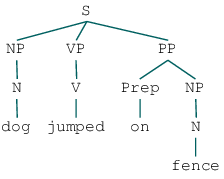

In [1]:
# Earley parser example.
import nltk
from IPython.display import display

grammar = nltk.CFG.fromstring("""
S -> NP VP
S -> NP  VP  PP
NP -> N
N -> "dog" | "fence"
VP -> V
V  -> "jumped"
PP -> Prep NP
Prep -> "on"
""")

parser = nltk.EarleyChartParser(grammar, trace=3)
sent = ['dog', 'jumped', 'on', 'fence']
tree = next(parser.parse(sent))
display(tree)

## Last Time

3 problems of Hidden Markov models:

1. **Likelihood:**
  - Given an HMM $\lambda = (A,B)$ and an observation sequence $O$
  - Compute the likelihood $p(O \mid \lambda)$.
  - I.e., what is the probability of this observation sequence given this HMM?
  - Solution: The Forward algorithm (dynamic program)
<br><br><br>  
2. **Decoding:**
  - Given an observation sequence $O$ and an HMM $\lambda=(A,B)$
  - Find the most probable sequence $Q$
  - Solution: The Viterbi algorithm
<br><br><br>
3. **Learning:** (Today)
  - Given an observation sequence $O$ and the set of states in the HMM
  - Learn the HMM parameters $A$ and $B$.


## Two types of learning:

1. **Supervised**: Input is a *labeled training set*   
$D = \{(\vec{o}_1, \vec{s}_1) \ldots (\vec{o}_k, \vec{s}_k)\}$ containing $k$ input observations $\vec{o}$ and their true labels $\vec{s}$.

2. **Unsupervised**: Input is an *unlabeled training set* $D = \{\vec{o}_1, \ldots \vec{o}_k\}$ and the number $n$ indicating the number of HMM states allowed.

## Supervised HMM Learning

- This uses the simple "counting" estimation we used for language models and naive Bayes

##### Transition probabilities

$$p(q_i \mid q_{i-1}) = \frac{C(q_{i-1}, q_i)}{C(q_{i-1})}$$

E.g., if the labeled training set $D$ has only two sentences:

> D &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; N &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; V &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; N  
> The &nbsp; dog &nbsp; ate &nbsp; food  
>  
> D &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; N &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; V &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  
> A black cat drank

Then we compute:

$$
p(N \mid D) = \frac{C(D, N)}{C(D)} = \frac{1}{2}
$$

We can again use add-$k$ smoothing, e.g., $k=1$:
$$
p(N \mid D) = \frac{C(D, N) + 1}{C(D) + N*k} = \frac{1+1}{2 + 4} = \frac{2}{6}
$$
- where  $N$ is the number of part of speech tags.

##### Emission probabilities

We can do the same to estimate the emission probabilities:

$$
p(o_i \mid q_i) = \frac{C(o_i, q_i)}{C(q_i)}
$$

e.g.

$$
p(dog \mid N) = \frac{C(dog, N)}{C(N)} = \frac{1}{3}
$$


##### Start/end transitions

We may optionally include probabilities to represent start and end transitions:


$$p(q_i \mid \mathrm{start} ) = \frac{C( \mathrm{start} , q_i)}{C(\mathrm{start})}$$

$$p(q_i \mid \mathrm{end}) = \frac{C(q_i, \mathrm{end})}{C(\mathrm{end})}$$

e.g.:

$$p(\mathrm{The} \mid \mathrm{start}) = \frac{1}{2}$$

For assignment 2, you will only estimate the start transition probabilities.
- Note: when computing smoothed estimate, the start states do not factor into the denominator:

$$
p(N \mid D) = \frac{C(D, N) + k}{C(D) + N*k} = \frac{1+1}{2 + 4} = \frac{2}{6}
$$


$$p(\mathrm{start} \mid D) = 0$$

- Note also: if we do not model end states, then when calculating transition probabilities, we handle the final tag in a sentence differently. E.g.
$$p(V \mid N) = \frac{C(N, V)}{C(N, *)} = \frac{2}{2} = 1$$
  - where $C(N, *)$ means "count the number of N tags followed by any other tag"
  - Thus, we ignore the "N" tag for "food" in the first sentence.
  - The reason for this is we need to have $\sum_i p(q_i \mid N)=1$.

## Unsupervised HMM Learning

Input is an *unlabeled training set* $D = \{\vec{o}_1, \ldots \vec{o}_k\}$ and the number $n$ indicating the number of HMM states allowed.

How can we possibly learn $p(q_i \mid q_{i-1})$ and $p(o_i \mid q_i)$ without any data about $q$?

Crazy idea:
- Initialize the probabilities randomly.
- Repeat:
  - Predict the labels for all the unlabeled data.
  - Re-estimate the probabilities as if the predicted labels were the true labels.
  
This is called the **EM Algorithm** (Expectation-Maximization).
- We'll first describe it for Naive Bayes, then for HMMs

## EM for Naive Bayes 

Recall the Naive Bayes model:

$$
p(y|\vec{x}) = \frac{p(y)\prod_j p(x_{ij}|y)}{p(\vec{x})}
$$
- $y_ \in \{-1,1\}$ is a class label
- $\vec{x}_i \in \{0,1\}^k$ is $k$-dimensional binary vector indicating the words in document $i$

In supervised learning, we estimated $p(x_{ij} \mid y)$ from data:

$$p(x_{ij}=1 \mid y=1) = \frac{C(x_{ij}=1, y_i=1]}{C(y_i=1)}$$
i.e., what proportion of documents where $y=1$ have term $j$?

In unsupervised learning, we don't observe $y$, so we can't compute the above directly.

To apply EM to Naive Bayes, we begin by initializing $p(x_{ij} \mid y)$ randomly (though still a valid distribution). Then, we repeat two steps:

1. **Expectation:** For each unlabeled document $x_i$, we compute the distribution over class labels $p(y|\vec{x})$ using the current version of the classifier.

  - $ \mu_i^1 = p(y_i=1 \mid \vec{x}_i) $ ; $ \mu_i^0 = p(y_i=0 \mid \vec{x}_i)$
  
2. **Maximization:** Recompute probabilities using weighted average over possible labels to document $i$
  - $p(x_{ij}=1 \mid y=1) = \frac{\sum_i p(y_i=1 \mid \vec{x}_i) 1[x_{ij} = 1]}{\sum_i p(y_i=1 \mid \vec{x}_i)}$
  - where $1[x_{ij}=1]$ means document $i$ has term $j$.
  - Note that this is a **weighted average**, using the probabilities $p(y_i \mid \vec{x}_{ij})$ to weight the counts.

## EM for HMMs

In HMMs, we have to compute the transition and emission probabilities:

$$
p(q_i \mid q_{i-1}) = \frac{C(q_{i-1}, q_i)}{C(q_{i-1})}
$$

$$
p(o_i \mid q_i) = \frac{C(o_i, q_i)}{C(q_i)}
$$

Since we don't observe $q$, we will use EM to compute weighted versions of these formula. What we want is:

$\hat{p}( q_i \mid q_j)$ =  
expected number of transitions from state $j$ to $i$ /  
expected number of transitions from state $j$.

First, recall the forward probability:

$$\alpha_t(j) = p(o_1 \ldots o_t, q_t=j \mid \lambda)$$    
$$= \sum_{i=1}^N \alpha_{t-1}(i)a_{ij}b_j(o_t)$$

This is the probability of being in state $j$ after seeing the first $t$ observations, given the automaton $\lambda$.

We can define an analogous probability, using future observations:


##### Backward probability
The probability of seeing observations from $t+1$ to the end of the sentence, given that we are in state $i$ at time $t$:

$$ \beta_t(i) = p(o_{t+1} \ldots o_T \mid q_t = i, \lambda)$$  
$$  = \sum_{j=1}^N a_{ij}b_j(o_{t+1})\beta_{t+1}(j) $$

![back](figs/back.png)

We will use forward and backward probabilities to compute the probability of a transition from state $i$ to $j$ at time $t$ in a sentence. Define this term as:

$$\xi_t(i, j) = p(q_t=i, q_{t+1}=j \mid O, \lambda)$$

<br>

To compute $\xi_t(i, j)$, note that
$$
p(q_t=i, q_{t+1}=j \mid O, \lambda) = \frac{p(q_t=i, q_{t+1}=j,  O \mid \lambda) }{p(O \mid \lambda)}
$$
e.g.
$$ p(X \mid Y, Z) = \frac{p(X, Y \mid Z)}{p(Y \mid Z)}$$

<br>

We can compute $p(q_t=i, q_{t+1}=j,  O \mid \lambda)$ using the forward and backward probabilities:

$$p(q_t=i, q_{t+1}=j,  O \mid \lambda) =$$  
$$= p(o_1 \ldots o_t, q_t=i) * p(q_{t+1} = j \mid q_t=i) * $$  
$$ p(o_{t+1} \mid q_{t+1} = j) * p(o_{t+2} \ldots o_T, \mid q_{t+1}=j)$$  
$$= \alpha_t(i)a_{ij}b_j(o_{t+1})\beta_{t+1}(j)$$

<br>
We can then divide by $p(O \mid \lambda) = \alpha_T(q_F)$:

$$\xi_t(i, j) = \frac{\alpha_t(i)a_{ij}b_j(o_{t+1})\beta_{t+1}(j)}{\alpha_T(q_F)}$$

<br><br>
Finally, to get the expected number of transitions from $i$ to $j$, we sum over all $t$ of $\xi$:

$$\hat{p}( q_i \mid q_j) =  \frac{\sum_{t=1}^{T-1} \xi_t(i, j)}{\sum_{t=1}^{T-1} \sum_{k=1}^N \xi(i, k)}$$

<br><br>
We do a similar computation to compute the expected emission probabilities:

$$
\hat{p}(o_i=k \mid q_i=j)
$$

$$
\gamma_t(j) = p(q_t = j \mid O, \lambda) = \frac{p(q_t=j, O \mid \lambda)}{P(O \mid \lambda)}
$$  
$$ = \frac{\alpha_t(j)\beta_t(j)}{p(O \mid \lambda)} $$

Finally

$$
\hat{p}(o_i=k \mid q_i=j) = \frac{\sum_{t=1  s.t. o_t=v_k}^T \gamma_t(j)}{\sum_{t=1}^T \gamma_t(j)}
$$
![gamma](figs/gamma.png)

![fb](figs/fb.png)


#### image sources
- https://www.cs.colorado.edu/~martin/SLP/


In [2]:
from IPython.core.display import HTML
HTML(open('../custom.css').read())